In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from ipywidgets import widgets

In [3]:
from tensorflow.keras.datasets import cifar10
# This gives you everything (images and labels) in 1 second
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

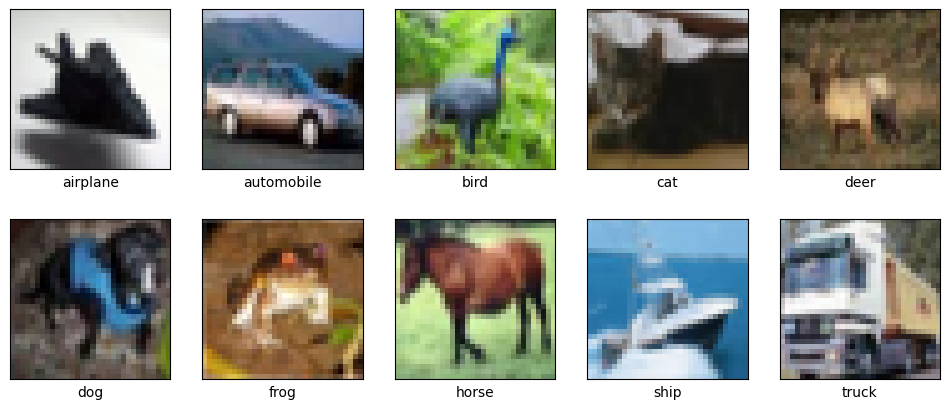

In [5]:
plt.figure(figsize=(12, 5))

# Loop through each of the 10 classes
for i in range(10):
    # Find the index of the first image belonging to class 'i'
    index = np.where(y_train == i)[0][0]

    # Select the image
    img = x_train[index]

    # Create a subplot
    plt.subplot(2, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img)
    plt.xlabel(class_names[i])

plt.show()

In [6]:
# --- Training Set Counts ---
unique_train, counts_train = np.unique(y_train, return_counts=True)
train_counts = dict(zip(class_names, counts_train))

print("--- Training Set ---")
for name, count in train_counts.items():
    print(f"Total training {name} images: {count}")

print("\n" + "-"*20 + "\n")

# --- Test Set Counts ---
unique_test, counts_test = np.unique(y_test, return_counts=True)
test_counts = dict(zip(class_names, counts_test))

print("--- Test Set ---")
for name, count in test_counts.items():
    print(f"Total test {name} images: {count}")

--- Training Set ---
Total training airplane images: 5000
Total training automobile images: 5000
Total training bird images: 5000
Total training cat images: 5000
Total training deer images: 5000
Total training dog images: 5000
Total training frog images: 5000
Total training horse images: 5000
Total training ship images: 5000
Total training truck images: 5000

--------------------

--- Test Set ---
Total test airplane images: 1000
Total test automobile images: 1000
Total test bird images: 1000
Total test cat images: 1000
Total test deer images: 1000
Total test dog images: 1000
Total test frog images: 1000
Total test horse images: 1000
Total test ship images: 1000
Total test truck images: 1000


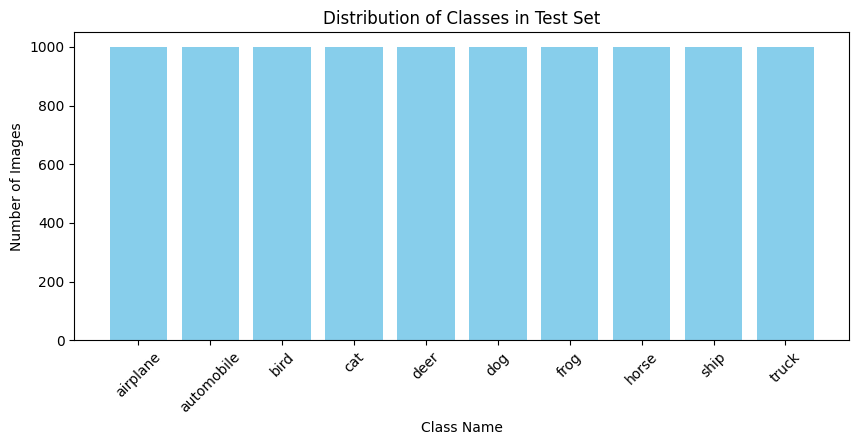

In [7]:
plt.figure(figsize=(10, 4))
plt.bar(test_counts.keys(), test_counts.values(), color='skyblue')
plt.title('Distribution of Classes in Test Set')
plt.xlabel('Class Name')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

In [8]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape = (32, 32, 3)),
    tf.keras.layers.Rescaling(1./255),
    # Convolution and Pooling layers
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    # 10 output neurons. It will contain a value from 0-9
    tf.keras.layers.Dense(10, activation = 'softmax')
])

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 361,034 (1.38 MB)

 Trainable params: 361,034 (1.38 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0001),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = ['accuracy']
)

In [11]:
# 1. Create the Training Dataset
# We use from_tensor_slices to convert NumPy arrays to a TF Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))

# 2. Create the Validation (Test) Dataset
validation_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

BATCH_SIZE = 32

train_dataset = train_dataset.shuffle(buffer_size=50000).batch(BATCH_SIZE)
validation_dataset = validation_dataset.batch(BATCH_SIZE)

print("Dataset objects created successfully!")

Dataset objects created successfully!


In [12]:
SHUFFEL_BUFFER_SIZE = 50000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
train_dataset_final = train_dataset.cache().shuffle(SHUFFEL_BUFFER_SIZE).prefetch(PREFETCH_BUFFER_SIZE)
validation_dataset_final = validation_dataset.cache().prefetch(PREFETCH_BUFFER_SIZE)

In [13]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',     # Watch the validation loss
    patience=2,             # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True # Revert the model to the weights from the best epoch
)

history = model.fit(
    train_dataset_final,
    epochs=45,
    validation_data=validation_dataset_final,
    verbose=2,
    callbacks=[early_stopping]
)

Epoch 1/45
1563/1563 - 17s - 11ms/step - accuracy: 0.3044 - loss: 1.8866 - val_accuracy: 0.4058 - val_loss: 1.6577
Epoch 2/45
1563/1563 - 5s - 3ms/step - accuracy: 0.4212 - loss: 1.5796 - val_accuracy: 0.4786 - val_loss: 1.4770
Epoch 3/45
1563/1563 - 5s - 3ms/step - accuracy: 0.4740 - loss: 1.4550 - val_accuracy: 0.5216 - val_loss: 1.3653
Epoch 4/45
1563/1563 - 5s - 3ms/step - accuracy: 0.5058 - loss: 1.3737 - val_accuracy: 0.5525 - val_loss: 1.2917
Epoch 5/45
1563/1563 - 5s - 3ms/step - accuracy: 0.5315 - loss: 1.3079 - val_accuracy: 0.5732 - val_loss: 1.2296
Epoch 6/45
1563/1563 - 5s - 3ms/step - accuracy: 0.5545 - loss: 1.2561 - val_accuracy: 0.5863 - val_loss: 1.1801
Epoch 7/45
1563/1563 - 6s - 4ms/step - accuracy: 0.5726 - loss: 1.2093 - val_accuracy: 0.6059 - val_loss: 1.1422
Epoch 8/45
1563/1563 - 5s - 3ms/step - accuracy: 0.5850 - loss: 1.1729 - val_accuracy: 0.6139 - val_loss: 1.1051
Epoch 9/45
1563/1563 - 5s - 3ms/step - accuracy: 0.6007 - loss: 1.1363 - val_accuracy: 0.6224 

In [20]:
from io import BytesIO
from IPython.display import display

# 1. Create the widgets
uploader = widgets.FileUpload(accept="image/*", multiple=True)
out = widgets.Output()

def file_predict(filename, file_stream, output_area):
    """
    Loads the uploaded image, resizes it to 32x32,
    and predicts the CIFAR-10 class.
    """
    # Load image and resize to 32x32 to match CIFAR-10 model input
    img = tf.keras.utils.load_img(file_stream, target_size=(32, 32))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Create batch axis (1, 32, 32, 3)

    # Generate predictions
    predictions = model.predict(img_array, verbose=0)

    # Get the class with the highest probability
    class_idx = np.argmax(predictions[0])
    predicted_label = class_names[class_idx]
    confidence = 100 * np.max(predictions[0])

    with output_area:
        print(f"File: {filename} | Prediction: {predicted_label} ({confidence:.2f}%)")

def on_upload_change(change):
    uploaded_dict = change.new

    # Iterate through the dictionary values to get the file metadata
    for file_data in uploaded_dict.values():
        name = file_data['metadata']['name']
        content = file_data['content']

        file_predict(name, BytesIO(content), out)

# 2. Observe the value change and display
uploader.observe(on_upload_change, names='value')
display(uploader, out)

FileUpload(value={}, accept='image/*', description='Upload', multiple=True)

Output()

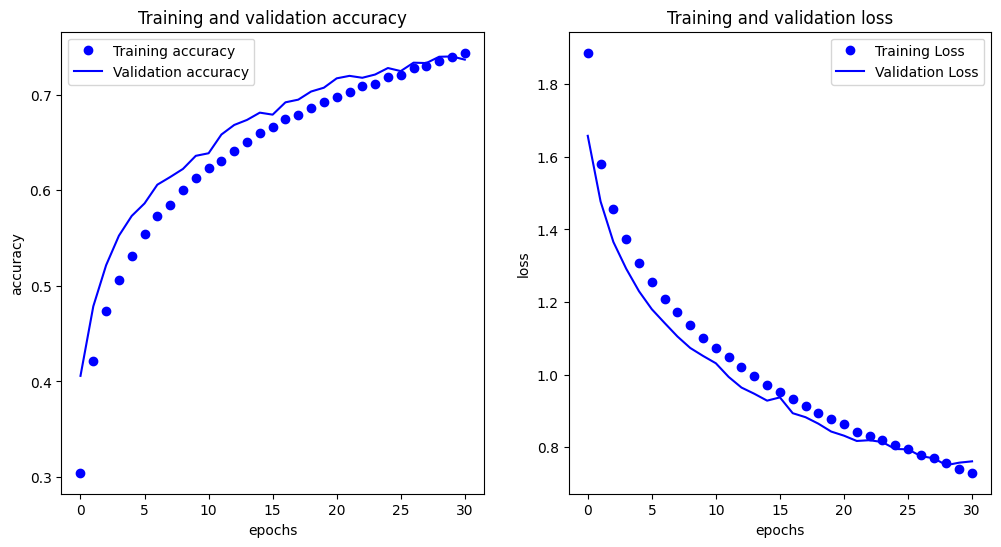

In [15]:
def plot_loss_acc(history):
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('accuracy')
    ax[0].legend()

    ax[1].plot(epochs, loss, 'bo', label='Training Loss')
    ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
    ax[1].set_title('Training and validation loss')
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('loss')
    ax[1].legend()

    plt.show()

plot_loss_acc(history)

In [16]:
from sklearn.metrics import classification_report

# 1. Get the model's predictions (probabilities) for the test set
# We use x_test directly or your validation_dataset_final
print("Generating predictions...")
predictions = model.predict(x_test, verbose=1)

# 2. Convert probabilities to class indices (0-9)
y_pred = np.argmax(predictions, axis=1)

# 3. Flatten y_test if necessary (it is usually shape (10000, 1))
y_true = y_test.flatten()

# 4. Generate and print the report
report = classification_report(y_true, y_pred, target_names=class_names)
print("\nClassification Report:\n")
print(report)

Generating predictions...
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification Report:

              precision    recall  f1-score   support

    airplane       0.80      0.74      0.77      1000
  automobile       0.81      0.88      0.84      1000
        bird       0.73      0.56      0.63      1000
         cat       0.59      0.54      0.56      1000
        deer       0.66      0.73      0.69      1000
         dog       0.67      0.64      0.66      1000
        frog       0.74      0.85      0.79      1000
       horse       0.77      0.78      0.78      1000
        ship       0.80      0.87      0.83      1000
       truck       0.82      0.80      0.81      1000

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000



In [17]:
model.save('cifar10_model.keras')